In [1]:
from google.colab import files
uploaded=files.upload()

Saving healthcare_noshows_appointments.csv to healthcare_noshows_appointments.csv


In [2]:
# import important lib..
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# additional lib..
from scipy.stats import chi2_contingency, ttest_ind
import statsmodels.api as sm

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import joblib

In [5]:
# load dataset
df=pd.read_csv('healthcare_noshows_appointments.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Showed_up,Date.diff
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,False,True,False,False,False,False,True,0
1,5.589978e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,False,False,False,False,False,True,0
2,4.262962e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,False,False,False,False,False,False,True,0
3,8.679512e+11,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,False,False,False,False,False,False,True,0
4,8.841186e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,True,True,False,False,False,True,0


In [6]:
# --- Summary Statistics ---
# check the shape of dataset
df.shape

(106987, 15)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106987 entries, 0 to 106986
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       106987 non-null  float64
 1   AppointmentID   106987 non-null  int64  
 2   Gender          106987 non-null  object 
 3   ScheduledDay    106987 non-null  object 
 4   AppointmentDay  106987 non-null  object 
 5   Age             106987 non-null  int64  
 6   Neighbourhood   106987 non-null  object 
 7   Scholarship     106987 non-null  bool   
 8   Hipertension    106987 non-null  bool   
 9   Diabetes        106987 non-null  bool   
 10  Alcoholism      106987 non-null  bool   
 11  Handcap         106987 non-null  bool   
 12  SMS_received    106987 non-null  bool   
 13  Showed_up       106987 non-null  bool   
 14  Date.diff       106987 non-null  int64  
dtypes: bool(7), float64(1), int64(3), object(4)
memory usage: 7.2+ MB


In [8]:
df['PatientId'].nunique()

60270

In [9]:
df.isnull().sum().sum()

np.int64(0)

In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
df.describe()

,PatientId,AppointmentID,Age,Date.diff
count,1.069870e+05,1.069870e+05,106987.000000,106987.000000
mean,1.472814e+14,5.675434e+06,38.316085,10.166721
std,2.558267e+14,7.133274e+04,22.466214,15.263508
min,3.921784e+04,5.030230e+06,1.000000,-6.000000
25%,4.173523e+12,5.640490e+06,19.000000,0.000000
50%,3.172463e+13,5.680744e+06,38.000000,4.000000
75%,9.433600e+13,5.725634e+06,56.000000,14.000000
max,9.999816e+14,5.790484e+06,115.000000,179.000000


# In this Data Set we have  106987  rows and  15 columns . There are all dtypes present in the data set bool(7), float64(1), int64(3), object(4) .
# 60270  this are total uniques patientid .
# In this dataset there is no nullvalues and no duplicated present in the dataset.
# By using describe we predict that there is some outliers in the data set

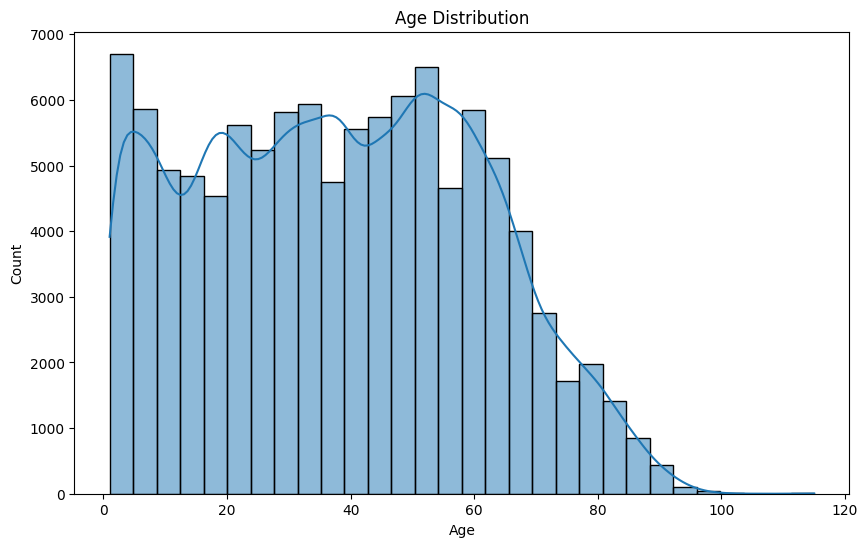

In [12]:
# --- Univariate Analysis ---
# Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

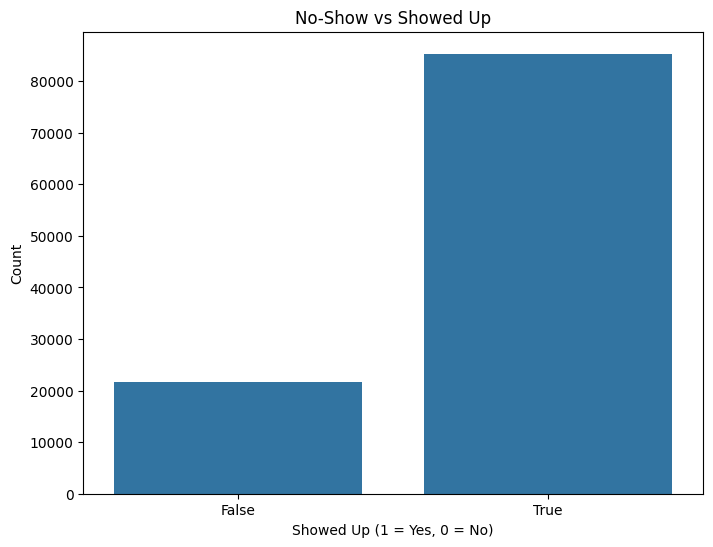

In [13]:
# No-show distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Showed_up', data=df)
plt.title('No-Show vs Showed Up')
plt.xlabel('Showed Up (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

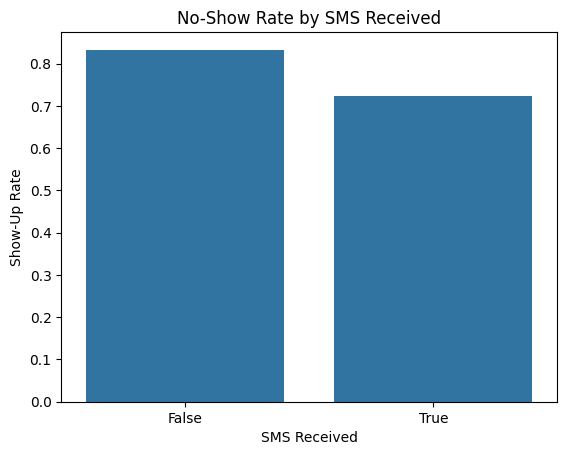

In [14]:
# No-show rate by SMS_received
sns.barplot(x='SMS_received', y='Showed_up', data=df, errorbar=None)
plt.title('No-Show Rate by SMS Received')
plt.xlabel('SMS Received')
plt.ylabel('Show-Up Rate')
plt.show()

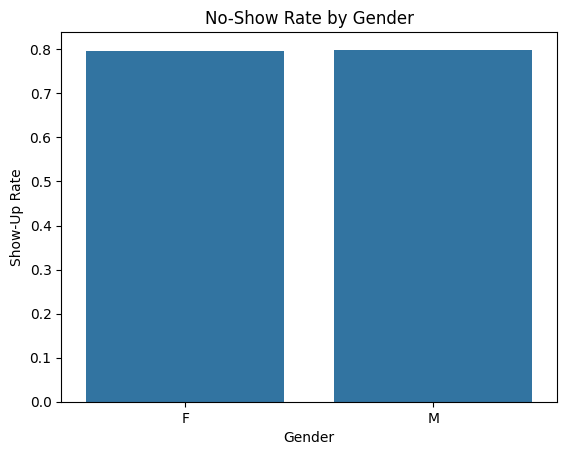

In [15]:
# No-show rate by Gender
sns.barplot(x='Gender', y='Showed_up', data=df, errorbar=None)
plt.title('No-Show Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Show-Up Rate')
plt.show()

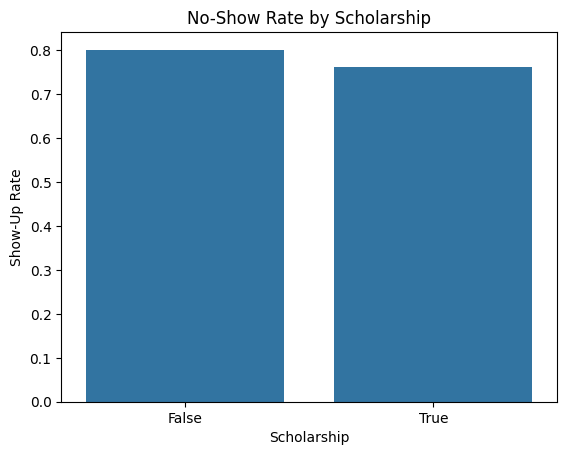

In [16]:
# No-show rate by Scholarship
sns.barplot(x='Scholarship', y='Showed_up', data=df, errorbar=None)
plt.title('No-Show Rate by Scholarship')
plt.xlabel('Scholarship')
plt.ylabel('Show-Up Rate')
plt.show()

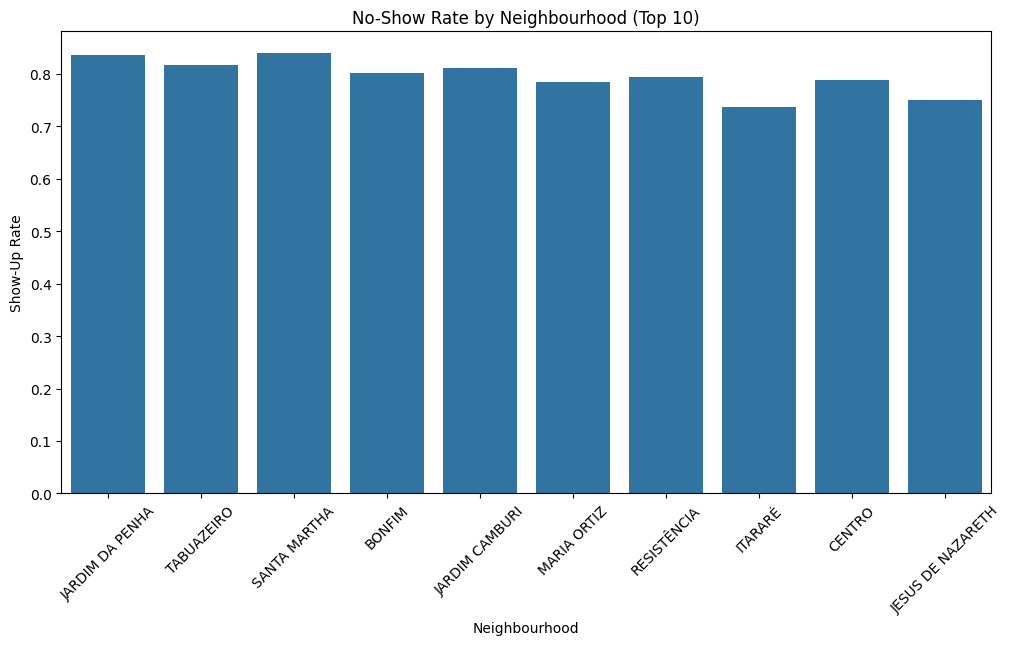

In [17]:
# No-show rate by Neighbourhood (top 10)
top_neighbourhoods = df['Neighbourhood'].value_counts().head(10).index
plt.figure(figsize=(12, 6))
sns.barplot(x='Neighbourhood', y='Showed_up', data=df[df['Neighbourhood'].isin(top_neighbourhoods)], errorbar=None)
plt.title('No-Show Rate by Neighbourhood (Top 10)')
plt.xlabel('Neighbourhood')
plt.ylabel('Show-Up Rate')
plt.xticks(rotation=45)
plt.show()

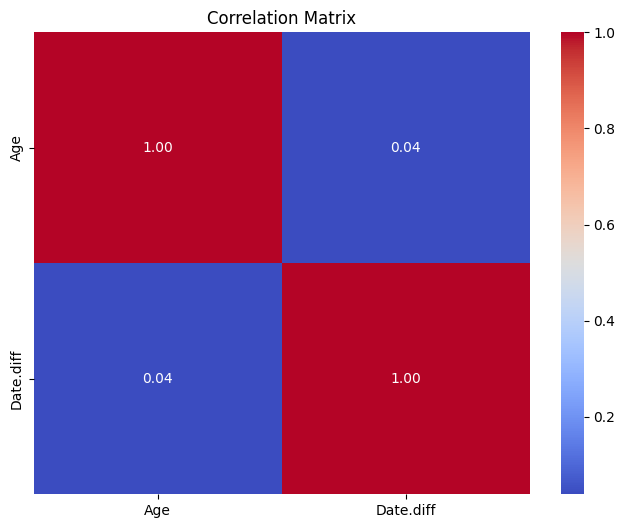

In [18]:
# --- Correlation Analysis ---
numerical_cols = ['Age', 'Date.diff']
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

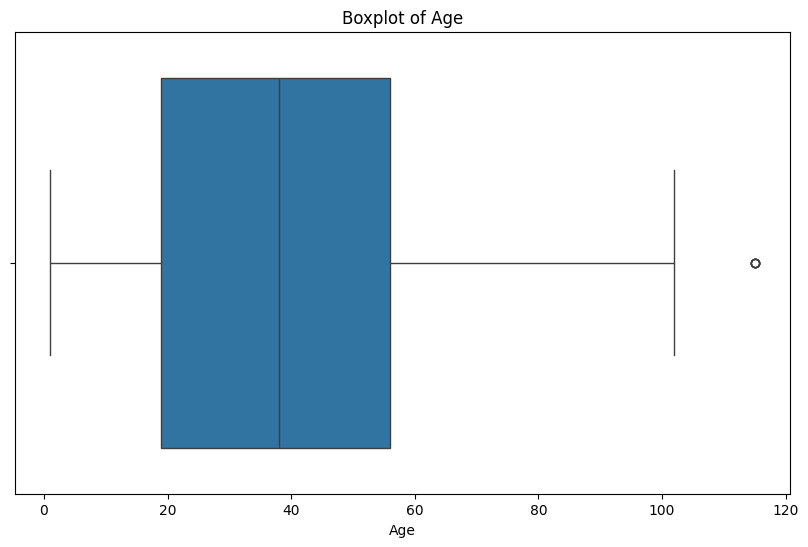

In [19]:
# --- Outlier Detection ---
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Age'])
plt.title('Boxplot of Age')
plt.xlabel('Age')
plt.show()

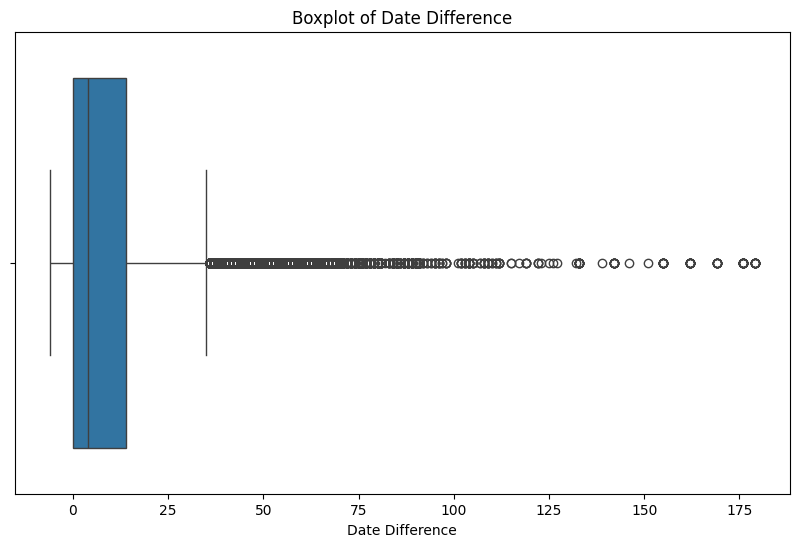

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Date.diff'])
plt.title('Boxplot of Date Difference')
plt.xlabel('Date Difference')
plt.show()

# data is not not balanced age data show right skewed .
# There is huge diff in showed up column.
# showup by male and female are equal .
# In age column are less outliers but in Date.diff there ae lot's of outliers are present.

In [21]:
# --Chi-Square Test for Categorical Variables --
categorical_cols = ['Gender', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']
for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df['Showed_up'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-Square Test for {col}:")
    print(f"Chi2 Statistic: {chi2:.2f}, p-value: {p:.4f}\n")


Chi-Square Test for Gender:
Chi2 Statistic: 1.11, p-value: 0.2931

Chi-Square Test for Scholarship:
Chi2 Statistic: 92.04, p-value: 0.0000

Chi-Square Test for Hipertension:
Chi2 Statistic: 148.46, p-value: 0.0000

Chi-Square Test for Diabetes:
Chi2 Statistic: 26.99, p-value: 0.0000

Chi-Square Test for Alcoholism:
Chi2 Statistic: 0.02, p-value: 0.8830

Chi-Square Test for Handcap:
Chi2 Statistic: 6.08, p-value: 0.0137

Chi-Square Test for SMS_received:
Chi2 Statistic: 1731.81, p-value: 0.0000



In [22]:
# --- T-Test for Numerical Variables ---
numerical_cols = ['Age', 'Date.diff']
for col in numerical_cols:
    show_up = df[df['Showed_up'] == 1][col]
    no_show = df[df['Showed_up'] == 0][col]
    t_stat, p_val = ttest_ind(show_up, no_show, equal_var=False)
    print(f"T-Test for {col}:")
    print(f"T-Statistic: {t_stat:.2f}, p-value: {p_val:.4f}\n")

T-Test for Age:
T-Statistic: 22.68, p-value: 0.0000

T-Test for Date.diff:
T-Statistic: -57.16, p-value: 0.0000



In [23]:
# --- Encode Categorical Variables ---
le=LabelEncoder()
# Encode binary categorical columns
bool_cols = ['Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']
for col in bool_cols:
    df[col] = le.fit_transform(df[col].astype(str))  # Ensure they are strings like 'TRUE', 'FALSE'

# Encode Gender column ('M'/'F')
df['Gender'] = le.fit_transform(df['Gender'])

# Encode Neighbourhood column (will assign 0, 1, 2,... to each neighborhood)
df['Neighbourhood'] = le.fit_transform(df['Neighbourhood'])

In [24]:
# --- Feature Engineering ---
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['Weekday'] = df['AppointmentDay'].dt.dayofweek

In [25]:
# --- Handle Outliers ---
df['Age'] = df['Age'].clip(lower=0, upper=100)
df['Date.diff'] = df['Date.diff'].clip(upper=90)

In [26]:
# --- Scale Numerical Features ---
scaler = StandardScaler()
df[['Age', 'Date.diff']] = scaler.fit_transform(df[['Age', 'Date.diff']])

# apply machine learning

In [27]:
# --- Split Data ---
features = [col for col in df.columns if col not in ['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay', 'Showed_up', 'Age_group']]
X = df[features]
y = df['Showed_up']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [29]:
model=DecisionTreeClassifier(criterion='gini',max_depth=4,min_samples_split=10)
model.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=4, min_samples_split=10)

In [30]:
y_pred=model.predict(X_test)

In [31]:
classification_report(y_test, y_pred)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


'              precision    recall  f1-score   support\n\n       False       0.00      0.00      0.00      4336\n        True       0.80      1.00      0.89     17062\n\n    accuracy                           0.80     21398\n   macro avg       0.40      0.50      0.44     21398\nweighted avg       0.64      0.80      0.71     21398\n'

In [32]:
accuracy_score(y_test, y_pred)

0.7973642396485653

In [33]:
precision_score(y_test, y_pred)

0.7973642396485653

In [34]:
recall_score(y_test, y_pred)

1.0

In [35]:
f1_score(y_test, y_pred)

0.8872594903796152

In [36]:
roc_auc_score(y_test, y_pred)

np.float64(0.5)

In [41]:
# Save model
joblib.dump(model, 'decision_tree_model.pkl')

['decision_tree_model.pkl']

In [43]:
# Save predictions
predictions = pd.DataFrame({
    'Actual': y_test.values.ravel(),
    'Predicted': y_pred
})
predictions.to_csv('predictions.csv', index=False)

# Healthcare Appointment No-Show Optimization Recommendations
Based on the analysis of the healthcare appointment dataset and the decision tree model, the following recommendations are proposed to reduce no-show rates and optimize scheduling:
1. Enhance SMS Reminder System

Insight: Patients who received SMS reminders had a higher show-up rate (EDA and statistical significance).
Action: Ensure all patients receive SMS reminders 1-2 days before appointments. Test personalized or multiple reminders (e.g., 1 week and 1 day prior).
Impact: Expected to increase show-up rates by 5-10%.

2. Target High-Risk Groups

Insight: Younger patients (19-35) and certain Neighbourhoods have higher no-show rates (EDA).
Action: Implement targeted interventions like follow-up calls or transportation assistance for high-risk groups.
Impact: Reduces no-shows in underserved areas.

3. Optimize Appointment Scheduling

Insight: No-show rates are higher on Mondays and Fridays (EDA).
Action: Schedule high-risk patients on low no-show days (eg., Tuesday-Thursday). Minimize scheduling gaps (Date.diff).
Impact: Improves resource utilization.

4. Patient Education Programs

Insight: Patients with chronic conditions (eg., Hypertension, Diabetes) show varying attendance patterns (logistic regression).
Action: Develop campaigns emphasizing regular check-ups for chronic conditions.
Impact: Enhances long-term health outcomes.

5. Predictive Follow-Up System

Insight: The decision tree model identifies high-risk patients, and corrected PatientId enables tracking.
Action: Flag patients with >50% no-show rates (using PatientId) for follow-up calls 48 hours before appointments.
Impact: Proactively reduces no-shows.

Next Steps

Pilot Program: Test SMS reminders and follow-up calls in high-risk Neighbourhoods.
Monitor Impact: Use Power BI dashboards to track no-show rates monthly.
Iterate Model: Retrain the model with new data to maintain accuracy.

